## Start of our student loan balance analysis

In [2]:
# Install packages
install.packages(c('janitor','car'))

Installing packages into 'C:/Users/namee/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'snakecase'




package 'snakecase' successfully unpacked and MD5 sums checked
package 'janitor' successfully unpacked and MD5 sums checked
package 'car' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\namee\AppData\Local\Temp\RtmpC2HJrr\downloaded_packages


In [ ]:
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)
library(glmnet)
library(car)
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)

## Data Cleaning

In [3]:
load_and_combine_data <- function(directory_path) {
  
  file_pattern <- glue(".*-Data\\.csv$")
  
  file_paths <- list.files(path = directory_path, pattern = file_pattern, full.names = TRUE)
  
  list_of_dfs <- map(file_paths, function(path) { 
    
    year_match_result <- regmatches(path, regexpr("Y(\\d{4})\\.*", path))
    
    year_extracted <- sub("Y(\\d{4})\\.*", "\\1", year_match_result)
    
    read.csv(path, skip = 1, na.strings = c("N", "-", "(X)", "null")) %>% 
      clean_names() %>%
      mutate(year = as.numeric(year_extracted)) %>%
      mutate(state = str_trim(str_extract(geographic_area_name, ",\\s*([^,]+)$"), side = "left"),
             state = str_replace(state, "^,\\s*", "")) %>%
      select(-contains(c("margin_of_error", "ratio", "unit", "percent", "x", "geograph")))
      }
    )
  
  common_columns <- names(list_of_dfs[[1]])
  
  for (i in 2:length(list_of_dfs)) {
    common_columns <- intersect(common_columns, names(list_of_dfs[[i]]))
  }
  
  list_of_dfs_common_cols <- map(list_of_dfs, ~ .x %>% select(all_of(common_columns)))
  
  for (col_name in common_columns) {
    first_col_type <- class(list_of_dfs_common_cols[[1]][[col_name]])
    
    if (first_col_type %in% c("numeric", "integer")) {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.numeric(df[[col_name]])
        df
      })
    } else if (first_col_type == "factor") {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.character(df[[col_name]])
        df
      })
    }
  }
  
  yearly_data <- bind_rows(list_of_dfs_common_cols)
  
  yearly_data
}

load_and_combine_borrower_data <- function(filepath, sheet_numbers, years) {

  combined_borrower_data <- map2_df(sheet_numbers, years, function(sheet, year) {
    read_excel(filepath, sheet = sheet, skip = 7) %>%
    clean_names() %>%
    mutate(year = year)
  })
  
  final_borrower_data <- combined_borrower_data %>%
    select(state, year, total_borrowers, total_balance_billions)
  
  final_borrower_data
}

dem_data <- load_and_combine_data("../data/dem") 
economic_data <- load_and_combine_data("../data/economic")
mean_income_data <- load_and_combine_data("../data/mean_income")
social_char_data <- load_and_combine_data("../data/social_char") 
borrower_data <-load_and_combine_borrower_data("../data/Student-loan-update-2025-Mangrum.xlsx", 11:15, 2019:2023)

dim(dem_data)

dem_data_cleaned <- dem_data %>%
  rename(total_population = estimate_race_total_population,
         race_white = estimate_race_total_population_one_race_white,
         race_black = estimate_race_total_population_one_race_black_or_african_american,
         race_asian = estimate_race_total_population_one_race_asian,
         race_native = estimate_race_total_population_one_race_american_indian_and_alaska_native,
         race_pacific_islander = estimate_race_total_population_one_race_native_hawaiian_and_other_pacific_islander,
         race_other = estimate_race_total_population_one_race_some_other_race,
         race_two_or_more = estimate_race_total_population_two_or_more_races,
         hispanic_or_latino = estimate_hispanic_or_latino_and_race_total_population_hispanic_or_latino_of_any_race,
         total_18_or_over_population = estimate_citizen_voting_age_population_citizen_18_and_over_population,
         population_18_or_over_male = estimate_citizen_voting_age_population_citizen_18_and_over_population_male,
         population_18_or_over_female = estimate_citizen_voting_age_population_citizen_18_and_over_population_female) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(race_two_or_more:hispanic_or_latino, ~./total_population),
         across(population_18_or_over_male:population_18_or_over_female, ~./total_18_or_over_population))

economic_data_cleaned <- economic_data %>%
  rename(employment_total = estimate_employment_status_population_16_years_and_over,
         employement_total_employed = estimate_employment_status_population_16_years_and_over_in_labor_force,
         employment_total_unemployed = estimate_employment_status_population_16_years_and_over_not_in_labor_force) %>%
  select(-contains("estimate"))  %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(employement_total_employed:employment_total_unemployed, ~./employment_total)) %>%
  select(-employment_total)

mean_income_data_cleaned <- mean_income_data %>%
  group_by(state, year) %>%
  summarise(mean_household_income_dollars = mean(estimate_mean_income_dollars_household_income_all_households, na.rm=TRUE)) %>%
  ungroup()

social_char_data_cleaned <- social_char_data %>%
  rename(average_household_size = estimate_households_by_type_total_households_average_household_size,
         total_veteran_eligible = estimate_veteran_status_civilian_population_18_years_and_over,
         total_veteran = estimate_veteran_status_civilian_population_18_years_and_over_civilian_veterans,
         total_population_degree = estimate_educational_attainment_population_25_years_and_over,
         total_population_bachelors_degree = estimate_educational_attainment_population_25_years_and_over_bachelor_s_degree_or_higher,
         total_foreign_born_pop = estimate_u_s_citizenship_status_foreign_born_population,
         total_households = estimate_households_by_type_total_households,
         total_household_w_internet = estimate_computers_and_internet_use_total_households_with_a_broadband_internet_subscription) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(-average_household_size, ~sum(., na.rm=TRUE)), 
            average_household_size = mean(average_household_size, na.rm=TRUE)) %>%
  ungroup() %>%
  mutate(total_veteran = total_veteran/total_veteran_eligible, 
         total_population_bachelors_degree = total_population_bachelors_degree/total_population_degree,
         total_household_w_internet = total_household_w_internet/total_households) %>%
  select(-c(total_veteran_eligible, total_population_degree, total_households))


combined_data <- dem_data_cleaned %>%
  left_join(economic_data_cleaned, by = c("state", "year")) %>%
  left_join(mean_income_data_cleaned, by = c("state", "year")) %>%
  left_join(social_char_data_cleaned, by = c("state", "year")) %>%
  left_join(borrower_data, by = c("state", "year")) %>%
  relocate(state, year) %>%
  filter(!state == "Puerto Rico", !state == "District of Columbia") %>%
  mutate(total_foreign_born_pop = total_foreign_born_pop/total_population,
         total_borrowers = total_borrowers/total_18_or_over_population) %>%
  select(-c(total_population, total_18_or_over_population))

# combined_data %>%
#   select(-state, -year) %>%
#   gtsummary::tbl_summary()

write.csv(combined_data, "../data/combined_clean_data.csv", row.names = FALSE)
cat("Save successful! Check `data/`")


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test




'data.frame':	16106 obs. of  50 variables:
 $ estimate_race_total_population                                                                                                    : num  55380 212830 25361 22493 57681 ...
 $ estimate_race_total_population_one_race                                                                                           : num  54182 209241 25057 22352 56765 ...
 $ estimate_race_total_population_two_or_more_races                                                                                  : num  1198 3589 304 141 916 ...
 $ estimate_race_total_population_one_race_1                                                                                         : num  54182 209241 25057 22352 56765 ...
 $ estimate_race_total_population_one_race_white                                                                                     : num  42527 183471 11869 17272 55062 ...
 $ estimate_race_total_population_one_race_black_or_african_american                       

`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.


In [ ]:
# Scratch work - MLR
set.seed(123)

student_debt_data <- read.csv("../data/combined_clean_data.csv")

train_idx <- sample(seq_len(nrow(student_debt_data)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_data[train_idx, ]
test_data <- student_debt_data[-train_idx, ]
# Prep train data
train_data <- train_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
# Prepare test data
test_data <- test_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
colnames(test_data)
colnames(train_data)
#mlr_model <- lm(total_balance_billions ~ . -year, data = train_data)
mlr_model <- lm(total_balance_billions ~ ., data = train_data)

summary(mlr_model)
vif(mlr_model)

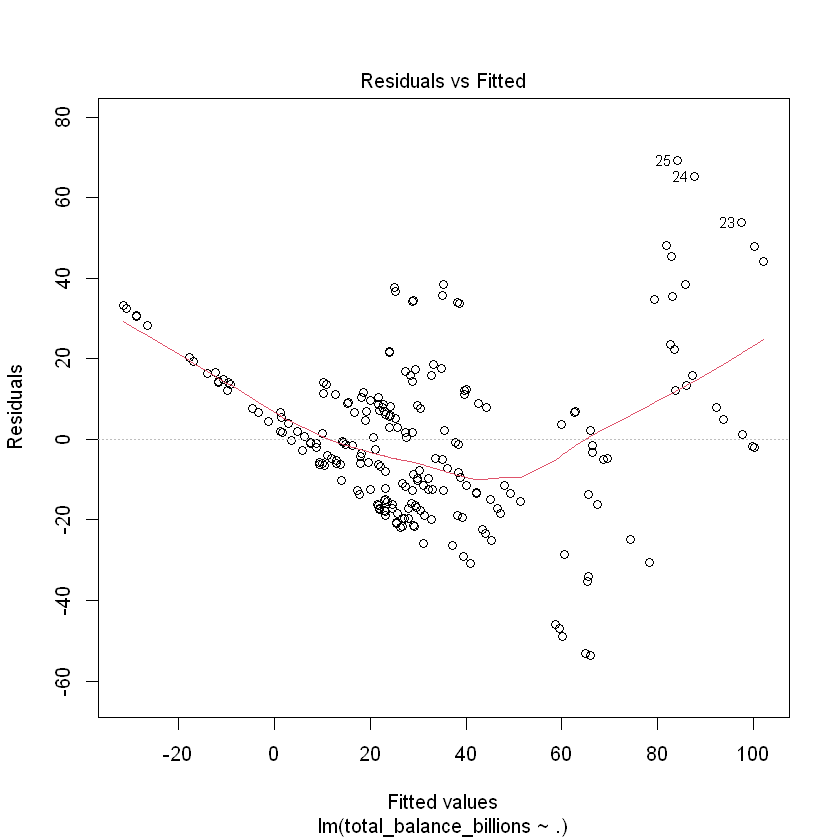

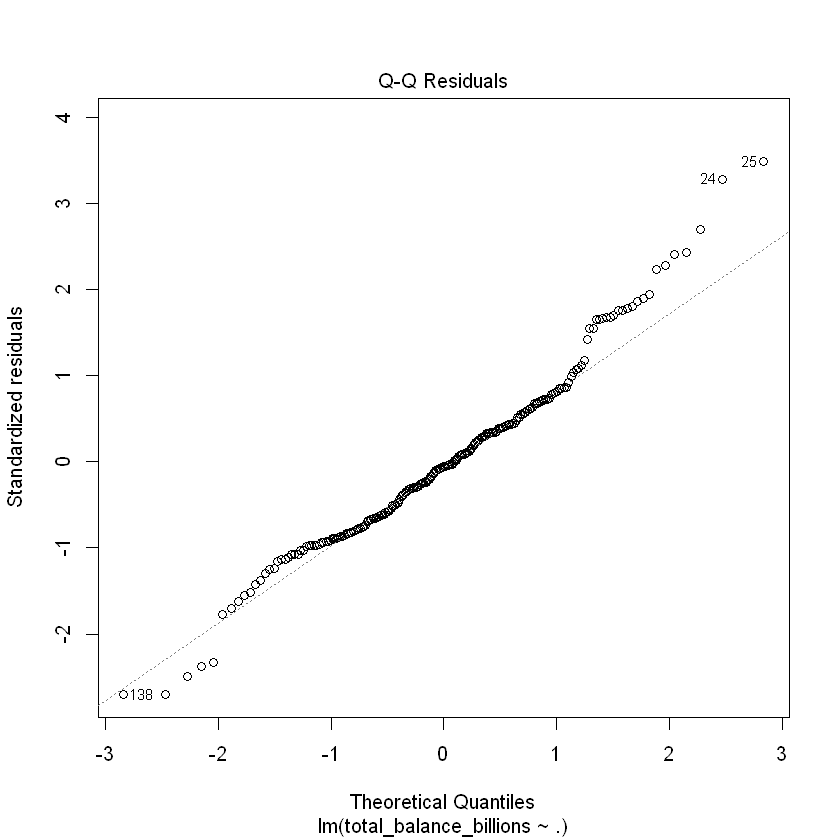

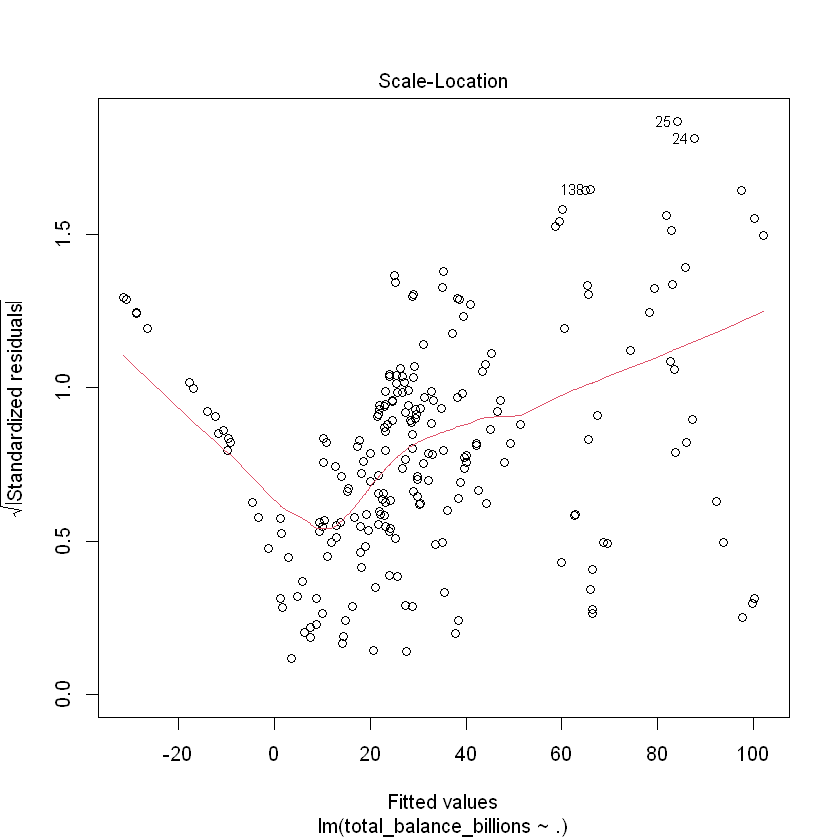

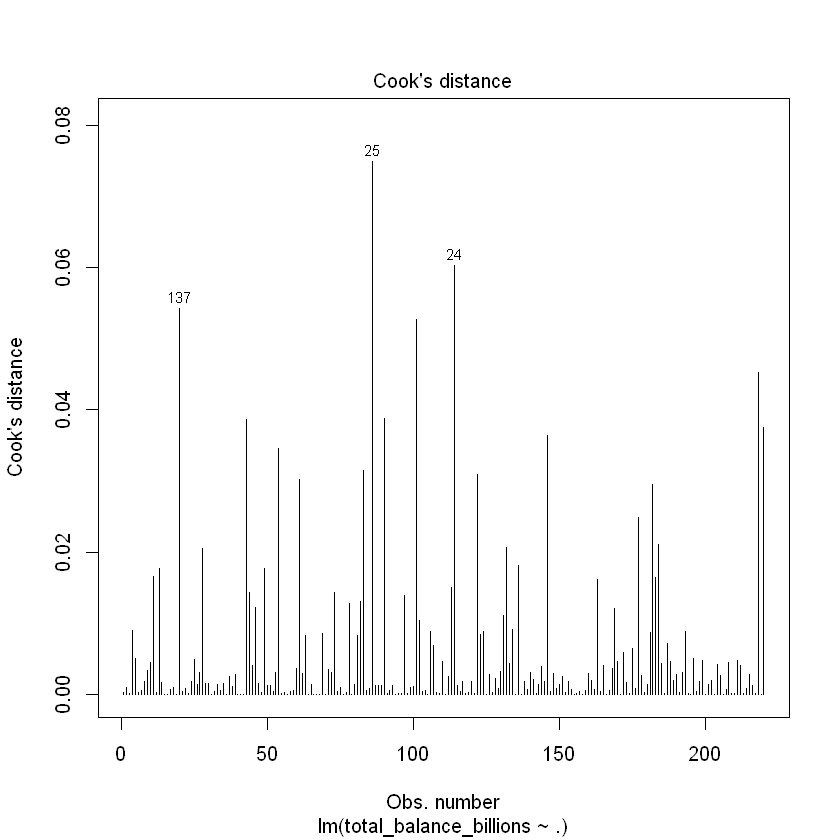

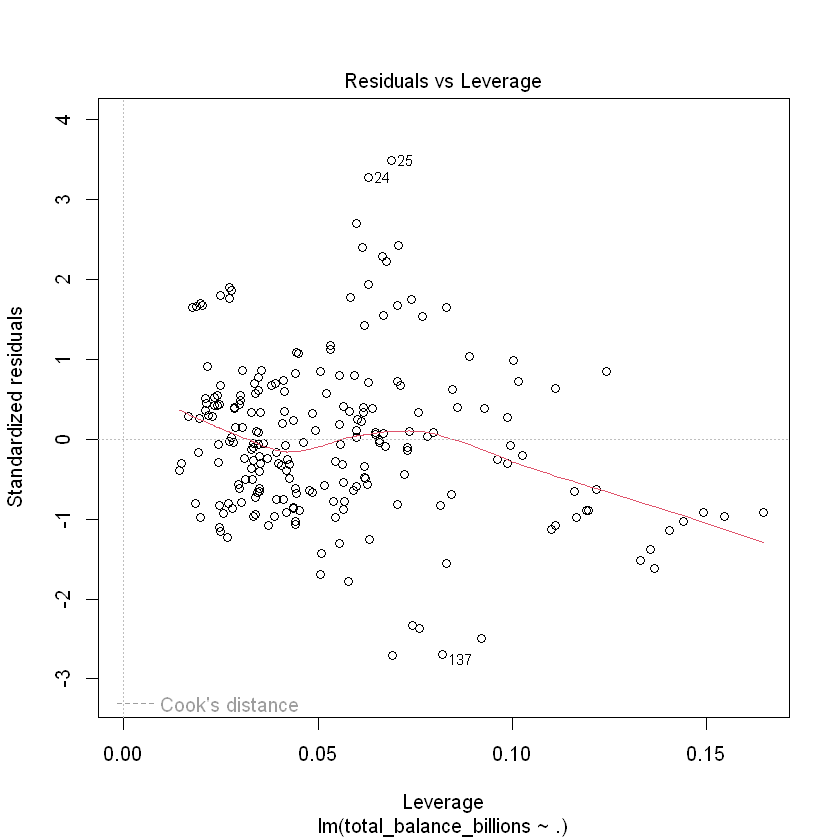

In [7]:
plot(mlr_model, which = 1)
plot(mlr_model, which = 2)
plot(mlr_model, which = 3)
plot(mlr_model, which = 4)
plot(mlr_model, which = 5)

In [10]:
mlr_model_transformed <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed)


Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50590 -0.43261  0.02354  0.40901  1.14826 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.655e+00  3.042e+00   1.530   0.1274    
hispanic_or_latino                -4.288e-01  5.672e-01  -0.756   0.4505    
population_18_or_over_male        -1.586e+01  7.264e+00  -2.184   0.0301 *  
employement_total_employed        -5.795e+00  2.161e+00  -2.682   0.0079 ** 
mean_household_income_dollars     -5.494e-05  4.904e-06 -11.203  < 2e-16 ***
total_population_bachelors_degree  3.271e+00  1.545e+00   2.118   0.0354 *  
total_veteran                     -2.049e+01  3.505e+00  -5.845 1.94e-08 ***
total_foreign_born_pop             9.526e+00  1.326e+00   7.183 1.19e-11 ***
total_household_w_internet         1.173e+01  1.652e+00   7.104 1.89e-11 ***
average_household_size             3.18

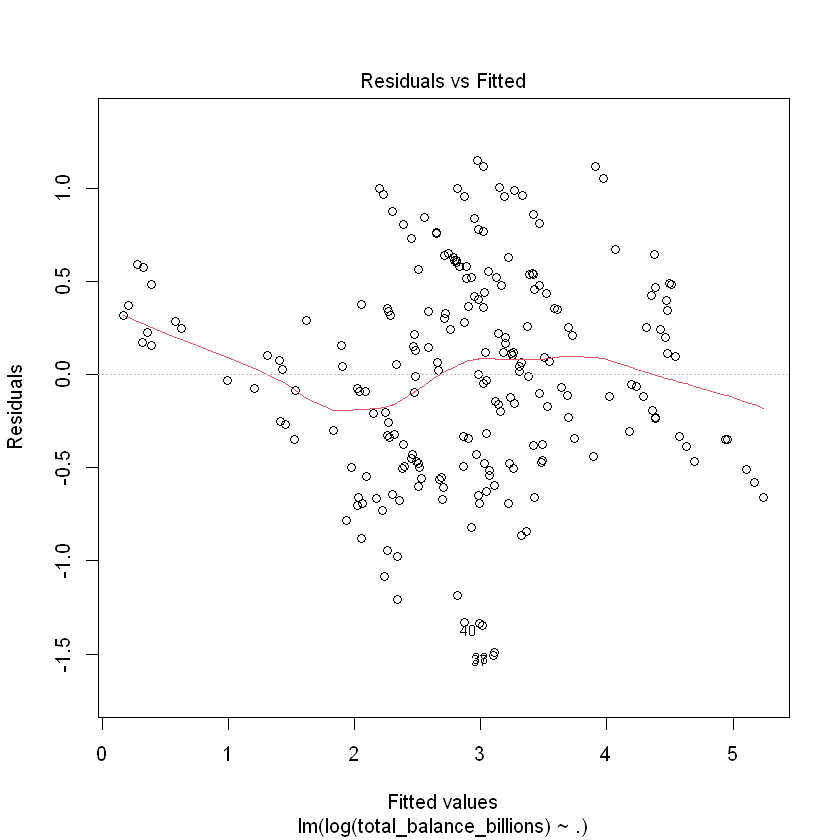

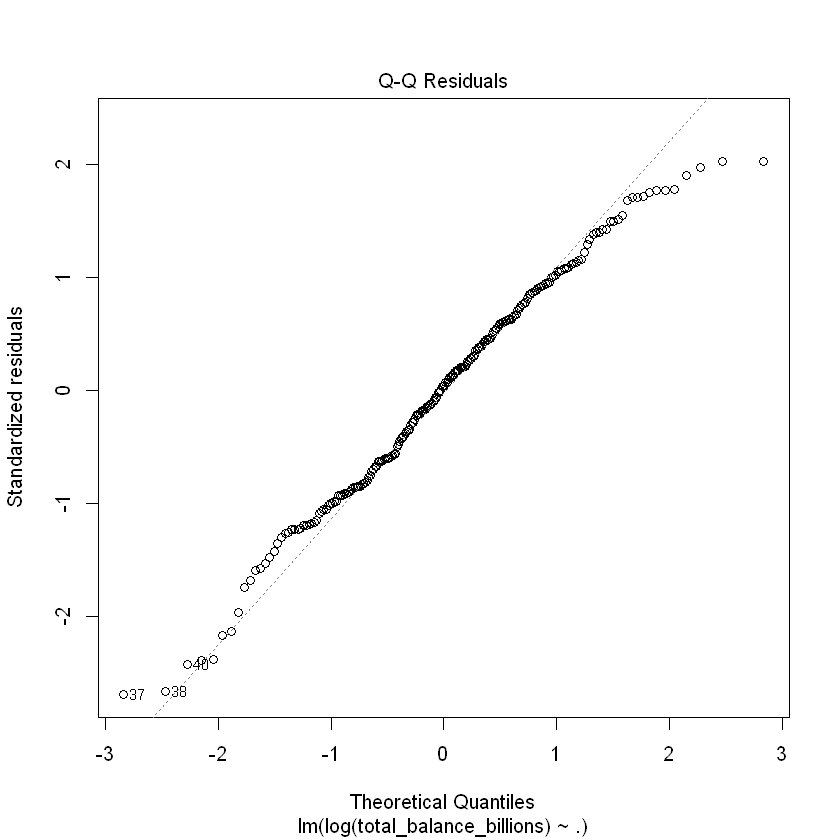

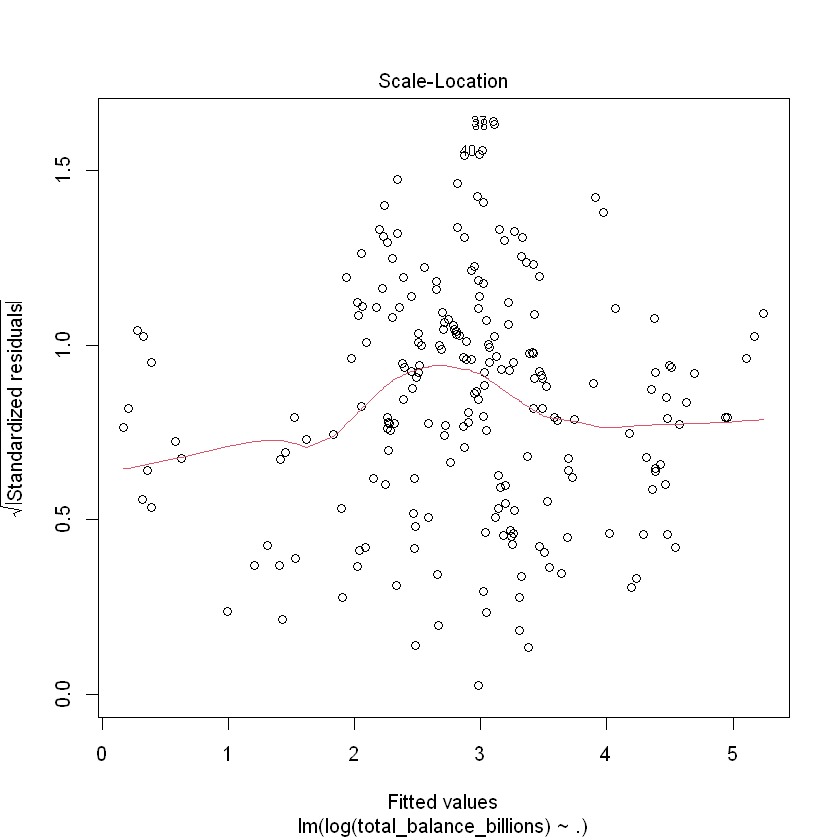

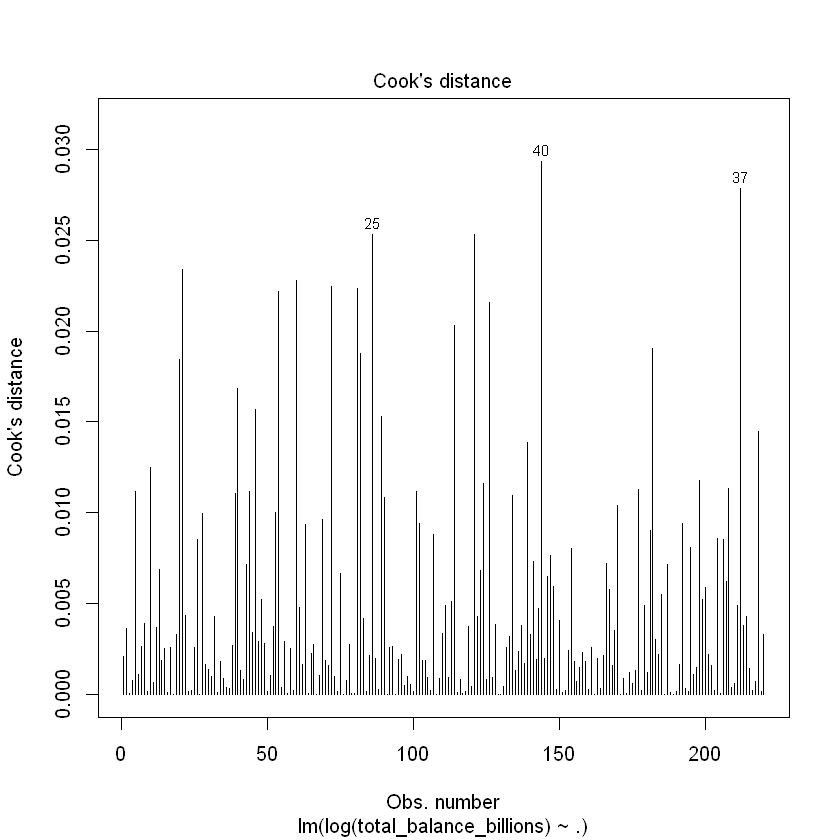

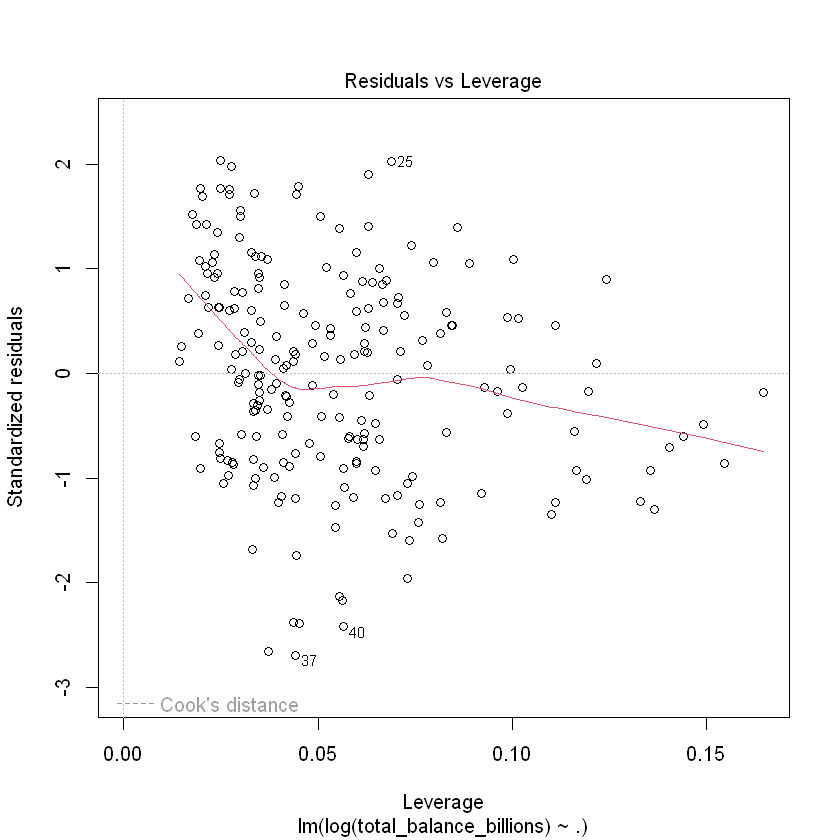

In [11]:
plot(mlr_model_transformed, which = 1)
plot(mlr_model_transformed, which = 2)
plot(mlr_model_transformed, which = 3)
plot(mlr_model_transformed, which = 4)
plot(mlr_model_transformed, which = 5)

# Step 0. Data Cleaning (Done)
- Read demographics and social characteristics data from the US census website
- Read the student loan and borrowed data from NY Fed Bank website
- Clean and model the data (standardize each data per state)
- Create train and test sets
# Step 1. Models to explore
- MLR Model (Done)
- Transformed MLR Model (Done)
- Clustered model (Done)
- Transformed clustered model
- Elastic Net: Variable selection

# Step 2. Goodness of fit tests/Model Assumptions
- Linearity
- Constant Variance
- Independence
- Normality

# Step 3. Prediction
- MLR
- Transformed
- Clustered
- Transformed clustered
- Elastic Net
- Look at the 5 models and actual value
- Predict with a threshold of 0.3
- Confusion matrix with specificity and sensitivity

# Step 4. Interpret
- Interpret the best model and explain why we chose the model and pitfalls of the model